In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import xgboost as xgb

In [2]:
train_df_original = pd.read_csv("D:/Pycharm/AutoLoanModel/Training Dataset.csv")
test_df_original = pd.read_csv("D:/Pycharm/AutoLoanModel/Testing Dataset.csv")
# Create copies for processing
train_df = train_df_original.copy()
test_df = test_df_original.copy()

In [3]:
# print("Train Data Info:")
# print(train_df.info())

In [4]:
# print("Test Data Info:")
# print(test_df.info())

In [5]:
# pd.unique(train_df['Gender'])

In [6]:
# Handling missing values (fill with median for numerical, mode for categorical)
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        train_df[col] = train_df[col].fillna(train_df[col].mode()[0])
        test_df[col] = test_df[col].fillna(test_df[col].mode()[0])
    else:
        train_df[col] = train_df[col].fillna(train_df[col].median())
        test_df[col] = test_df[col].fillna(test_df[col].median())


In [7]:
# Identify categorical columns
binary_categorical_cols = ['collateral_dlrinput_newused_1req']  # Binary categorical variables
multi_categorical_cols = ['Gender','Race']  # Multi-class categorical variables

# Label encode binary categorical variables
label_enc = LabelEncoder()
for col in binary_categorical_cols:
    train_df[col] = label_enc.fit_transform(train_df[col])
    test_df[col] = label_enc.transform(test_df[col])

# One-hot encode multi-class categorical variables
one_hot = OneHotEncoder(sparse_output=False)  # Drop first to avoid dummy variable trap
encoded_multi_train = one_hot.fit_transform(train_df[multi_categorical_cols])
encoded_multi_test = one_hot.transform(test_df[multi_categorical_cols])

In [8]:
# Convert to DataFrame
encoded_multi_train_df = pd.DataFrame(encoded_multi_train, columns=one_hot.get_feature_names_out(multi_categorical_cols))
encoded_multi_test_df = pd.DataFrame(encoded_multi_test, columns=one_hot.get_feature_names_out(multi_categorical_cols))

# Concatenate one-hot encoded data back to DataFrame
train_df = pd.concat([train_df.drop(columns=multi_categorical_cols), encoded_multi_train_df], axis=1)
test_df = pd.concat([test_df.drop(columns=multi_categorical_cols), encoded_multi_test_df], axis=1)

In [9]:
train_df.columns

Index(['fico', 'aprv_flag', 'amtfinanced_1req',
       'collateral_dlrinput_newused_1req', 'pti_1req', 'ltv_1req',
       'p12_reh7120_a', 'p12_bcx7110_a', 'p12_all7170_a', 'p12_aut7110_a',
       'p12_all7120_a', 'p12_all7937_a', 'p12_bcc8120_a', 'p12_iln7410_a',
       'p12_rev1300_a', 'p12_all8150_a', 'p12_bca8370_a', 'p12_all7517_a',
       'p12_iln8220_a', 'p12_all6250_a', 'p12_aua8151_a', 'p12_rtr7110_a',
       'p12_pil8120_a', 'p12_aua0300_a', 'p12_all7938_a', 'p12_bcc3456_a',
       'p12_all8370_a', 'p12_aua8220_a', 'p12_als1300_a', 'p12_aua6200_a',
       'p12_all2427_a', 'p12_alm6200_a', 'p12_all6971_a', 'clntr9437_a',
       'clact9429_a', 'clall5010_a', 'clall2434_a', 'cloil0214_a',
       'cltra4405_a', 'clact9428_a', 'bad_flag', 'Gender_Female',
       'Gender_Male', 'Gender_Undefined', 'Race_Asian', 'Race_Black',
       'Race_Hispanic', 'Race_Other', 'Race_White'],
      dtype='object')

In [10]:
# Define features and target
X_train = train_df.drop(columns=['bad_flag', 'aprv_flag'])
y_train = train_df['bad_flag']
X_test = test_df.drop(columns=['bad_flag', 'aprv_flag'])
y_test = test_df['bad_flag']

# Standardize numerical features (excluding already-encoded categorical features)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# Train Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print("AUC-ROC Score:", roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1]))

Logistic Regression Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      5158
         1.0       0.17      0.00      0.01       242

    accuracy                           0.95      5400
   macro avg       0.56      0.50      0.49      5400
weighted avg       0.92      0.95      0.93      5400

AUC-ROC Score: 0.7849789623116141


In [12]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Report:")
print(classification_report(y_test, y_pred_xgb))
print("AUC-ROC Score:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))

XGBoost Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      5158
         1.0       0.29      0.02      0.05       242

    accuracy                           0.95      5400
   macro avg       0.62      0.51      0.51      5400
weighted avg       0.93      0.95      0.93      5400

AUC-ROC Score: 0.7678531944279768


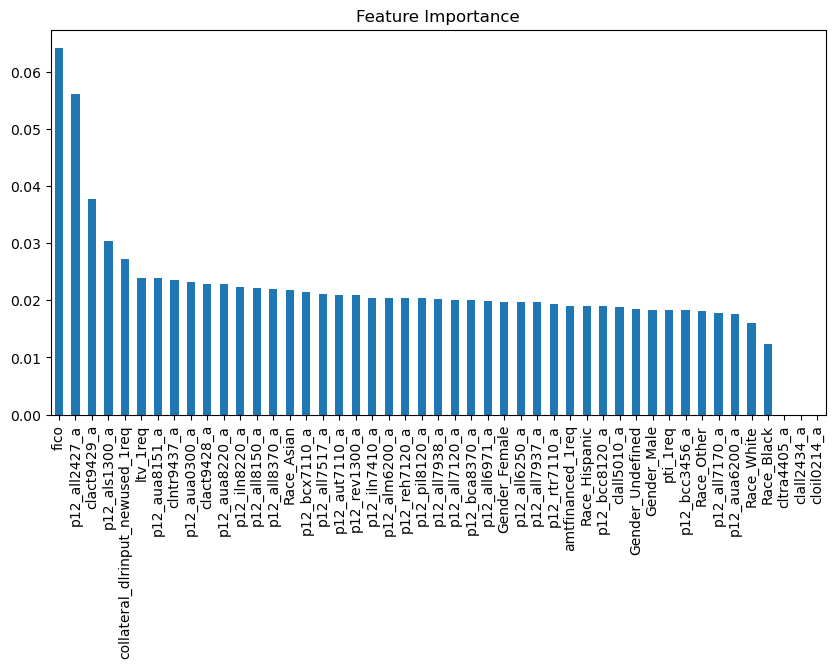

In [13]:

# Feature importance from XGBoost
feat_imp = pd.Series(xgb_model.feature_importances_, index=train_df.drop(columns=['bad_flag', 'aprv_flag']).columns)
feat_imp.sort_values(ascending=False).plot(kind='bar', figsize=(10,5), title='Feature Importance')
plt.show()

In [14]:
# # Bias Analysis
# def analyze_bias(df, group_col, target_col='aprv_flag'):
#     bias_report = df.groupby(group_col)[target_col].mean()
#     print(f"Approval Rates by {group_col}:")
#     print(bias_report)

# analyze_bias(train_df, 'Gender')
# analyze_bias(train_df, 'Race')

In [15]:
# race_columns = [col for col in train_df.columns if 'Race' in col]
# print("Encoded Race Columns:", race_columns)

# for col in race_columns:
#     analyze_bias(train_df, col)


In [16]:
def analyze_bias(df, group_col, target_col='aprv_flag', label_encoders=None, one_hot_mappings=None):
    """
    Analyzes approval rates by categorical groups.
    
    Parameters:
        df (pd.DataFrame): Dataframe containing the data.
        group_col (str): Encoded categorical column.
        target_col (str): Target variable to analyze (default: 'aprv_flag').
        label_encoders (dict): Dictionary mapping column names to their fitted LabelEncoders.
        one_hot_mappings (dict): Dictionary mapping One-Hot encoded prefixes to original categories.
    """
    # Decode One-Hot Encoded columns (e.g., Gender, Race)
    if one_hot_mappings and group_col in one_hot_mappings:
        categories = one_hot_mappings[group_col]
        for category in categories:
            if category in df.columns:
                df[category] = df[category].map({1: category.split('_')[-1], 0: None})  # Extract label from column name
        
        df[group_col] = df[categories].bfill(axis=1).iloc[:, 0]  # Fill first non-null category

    # Perform bias analysis
    bias_report = df.groupby(group_col)[target_col].mean()
    
    print(f"\nApproval Rates by {group_col}:")
    print(bias_report)

# Store One-Hot Encoded Columns
one_hot_mappings = {
    'Gender': [col for col in train_df.columns if col.startswith('Gender_')],
    'Race': [col for col in train_df.columns if col.startswith('Race_')]
}

# Run Bias Analysis using One-Hot Encoded Gender
analyze_bias(train_df, 'Gender', one_hot_mappings=one_hot_mappings)
analyze_bias(train_df, 'Race', one_hot_mappings=one_hot_mappings)



Approval Rates by Gender:
Gender
Female       0.728821
Male         0.743788
Undefined    0.758311
Name: aprv_flag, dtype: float64

Approval Rates by Race:
Race
Asian       0.745487
Black       0.724243
Hispanic    0.738487
Other       0.739070
White       0.741318
Name: aprv_flag, dtype: float64


In [17]:






# Save results
train_df.to_csv("processed_train.csv", index=False)
test_df.to_csv("processed_test.csv", index=False)
